In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from functools import partial

In [3]:
# import gymnasium as gym
# import gym as gym_old
import gym

In [13]:
from tqdm.auto import tqdm

In [4]:
import procgen

In [5]:
import cv2

In [19]:
from ppo import *

In [24]:
env = make_single_env()

In [41]:
env.reset()
for i in tqdm(range(1000)):
    obs, reward, done, info = env.step(env.action_space.sample())
    if done:
        break

100%|█████████▉| 999/1000 [00:00<00:00, 6264.20it/s]


In [42]:
env = make_env(10)

In [43]:
obs = env.reset()
obs, reward, done, info = env.step(env.action_space.sample())

In [44]:
info

{'prev_level_seed': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'prev_level_complete': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'level_seed': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [46]:
obs = env.reset()
for i in tqdm(range(1000)):
    obs, reward, done, info = env.step(env.action_space.sample())


100%|██████████| 1000/1000 [00:02<00:00, 467.45it/s]


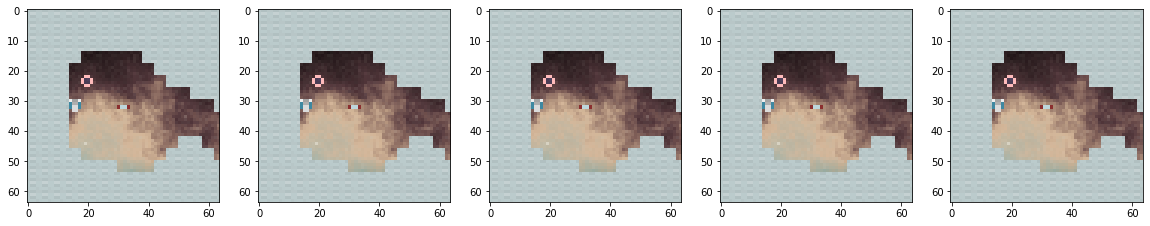

In [272]:
obs, info = env.reset()
plt.figure(figsize=(20, 5))
for i in range(len(obs)):
    plt.subplot(1, 5, i+1)
    plt.imshow(obs[i])
plt.show()

In [9]:
obs, reward, done, info = env.step(np.zeros(10))

In [10]:
done

array([False, False, False, False, False, False, False, False, False,
       False])

In [14]:
from ppo import layer_init

In [36]:

class RNDModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Prediction network
        self.predictor = nn.Sequential(
            layer_init(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=8, stride=4)),
            nn.LeakyReLU(),
            layer_init(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)),
            nn.LeakyReLU(),
            layer_init(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)),
            nn.LeakyReLU(),
            nn.Flatten(),
            layer_init(nn.Linear(7*7*64, 512)),
            nn.ReLU(),
            layer_init(nn.Linear(512, 512)),
            nn.ReLU(),
            layer_init(nn.Linear(512, 512)),
        )

        # Target network
        self.target = nn.Sequential(
            layer_init(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=8, stride=4)),
            nn.LeakyReLU(),
            layer_init(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)),
            nn.LeakyReLU(),
            layer_init(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)),
            nn.LeakyReLU(),
            nn.Flatten(),
            layer_init(nn.Linear(7*7*64, 512)),
        )

        # target network is not trainable
        for param in self.target.parameters():
            param.requires_grad = False

    def forward(self, next_obs):
        target_feature = self.target(next_obs)
        predict_feature = self.predictor(next_obs)
        print(target_feature.shape, predict_feature.shape)

        return predict_feature, target_feature

In [37]:
net = RNDModel()

In [39]:
a, b = net(torch.randn(10, 1, 64, 64))
# a.shape, b.shape

torch.Size([10, 64, 4, 4]) torch.Size([10, 64, 4, 4])


In [53]:
envs = ProcgenEnv(num_envs=5, env_name='coinrun', num_levels=0, start_level=0, distribution_mode="easy")
envs = gym.wrappers.TransformObservation(envs, lambda obs: obs["rgb"])
envs.single_action_space = envs.action_space
envs.single_observation_space = envs.observation_space["rgb"]
envs.is_vector_env = True
envs = gym.wrappers.RecordEpisodeStatistics(envs)
envs = gym.wrappers.NormalizeReward(envs, 0.99)
envs = gym.wrappers.TransformReward(envs, lambda reward: np.clip(reward, -10, 10))

In [55]:
envs.single_observation_space

Box(0, 255, (64, 64, 3), uint8)

In [166]:
env = gym.make('MontezumaRevengeNoFrameskip-v4')

In [168]:
obs, info = env.reset()

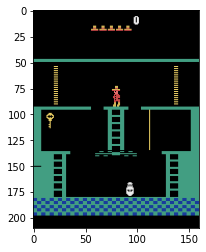

In [170]:
plt.imshow(obs)